## Making Optical Properties

A short tutorial on generating bulk optical properties from mie tables and microphysical data.

In [1]:
#imports

import pyshdom
import numpy as np
import xarray as xr
from collections import OrderedDict

There are two ways to generate optical properties. We can either use an 'exact' generator which takes as input a mono-disperse Mie table and then decides how to optimally generate the poly disperse table or we can directly work from the poly-disperse table with a 'table' generator. 

The latter method has the drawback of possibly reduced accuracy but it is sufficiently general that it works with methods for which we don't have mono-disperse single scattering properties such as for optically complex ice crystals and non-spherical aerosol.

**NB Currently this tutorial only covers the 'exact' method which is better for Mie scattering where we can easily calculate the mono disperse single scatter properties. As of writing the 'table' generator has not been refactored so it is not included.**

### Microphysical Data

For this example we will just make use of one of the clouds that is distributed with pyshdom.

In [33]:
# load the scatterer.
cloud_scatterer = pyshdom.util.load_from_csv('../data/synthetic_cloud_fields/jpl_les/rico32x37x26.txt',
                                           density='lwc',origin=(0.0,0.0))

This file only defines the cloud at grid points for which the liquid water content is non-zero. 
When we interpolate this cloud data onto the merged grid using `pyshdom.grid.resample_onto_grid` that will be used for all optical properties
some filling rules are applied to define these values.

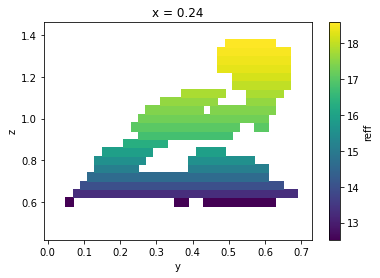

In [34]:
cloud_scatterer.reff[12].T.plot()

In [35]:
#make a grid for microphysics which is just the cloud grid.
rte_grid = pyshdom.grid.make_grid(cloud_scatterer.x.diff('x')[0],cloud_scatterer.x.data.size,
                          cloud_scatterer.y.diff('y')[0],cloud_scatterer.y.data.size,
                          cloud_scatterer.z)

In [36]:
cloud_scatterer_on_rte_grid = pyshdom.grid.resample_onto_grid(rte_grid, cloud_scatterer)
cloud_scatterer_on_rte_grid

<xarray.Dataset>
Dimensions:  (x: 32, y: 37, z: 26)
Coordinates:
  * x        (x) float64 0.0 0.02 0.04 0.06 0.08 0.1 ... 0.54 0.56 0.58 0.6 0.62
  * y        (y) float64 0.0 0.02 0.04 0.06 0.08 0.1 ... 0.64 0.66 0.68 0.7 0.72
  * z        (z) float64 0.44 0.48 0.52 0.56 0.6 ... 1.28 1.32 1.36 1.4 1.44
Data variables:
    delx     float64 0.02
    dely     float64 0.02
    density  (x, y, z) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    reff     (x, y, z) float64 11.69 11.69 11.69 11.69 ... 18.51 18.57 18.7 18.7
Attributes:
    density_name:  lwc
    file_name:     ../data/synthetic_cloud_fields/jpl_les/rico32x37x26.txt

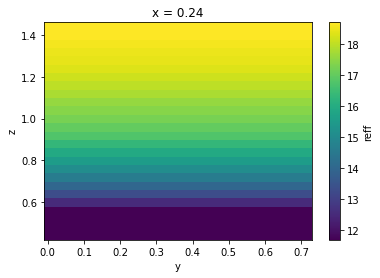

In [37]:
cloud_scatterer_on_rte_grid.reff[12].T.plot()

In [38]:
#We choose a gamma size distribution and therefore need to define a 'veff' variable.
size_distribution_function = pyshdom.size_distribution.gamma

cloud_scatterer_on_rte_grid['veff'] = (cloud_scatterer_on_rte_grid.reff.dims,
                                       np.full_like(cloud_scatterer_on_rte_grid.reff.data, fill_value=0.1))
cloud_scatterer_on_rte_grid

<xarray.Dataset>
Dimensions:  (x: 32, y: 37, z: 26)
Coordinates:
  * x        (x) float64 0.0 0.02 0.04 0.06 0.08 0.1 ... 0.54 0.56 0.58 0.6 0.62
  * y        (y) float64 0.0 0.02 0.04 0.06 0.08 0.1 ... 0.64 0.66 0.68 0.7 0.72
  * z        (z) float64 0.44 0.48 0.52 0.56 0.6 ... 1.28 1.32 1.36 1.4 1.44
Data variables:
    delx     float64 0.02
    dely     float64 0.02
    density  (x, y, z) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    reff     (x, y, z) float64 11.69 11.69 11.69 11.69 ... 18.51 18.57 18.7 18.7
    veff     (x, y, z) float64 0.1 0.1 0.1 0.1 0.1 0.1 ... 0.1 0.1 0.1 0.1 0.1
Attributes:
    density_name:  lwc
    file_name:     ../data/synthetic_cloud_fields/jpl_les/rico32x37x26.txt

### Exact OpticalPropertyGenerator

For the exact optical property generator we still need to define a look up table spacing for the
microphysical variables. This is because the `exact` mode for the optical property generator may be too memory intensive if there are a large number of unique phase functions. When `maxnphase` is exceeded or the maximum table size is exceeded then it will swap variables to `table` mode.

Note that the generator is set up and can then be called on any input dataset without any guarentee that they
are matched correctly. All that is required is that the microphysical dimensions defined in the initialization are all supplied by the input microphysics dataset.

In [39]:
mie_mono_table = pyshdom.mie.get_mono_table(
    'Water',(0.86,0.86),
    max_integration_radius=65.0,
    minimum_effective_radius=0.1,
    relative_dir='../mie_tables',
    verbose=False
)
mie_mono_tables = OrderedDict()
mie_mono_tables[0.86] = mie_mono_table

In [40]:
optical_prop_gen = pyshdom.medium.OpticalPropertyGenerator(
    'cloud',
    mie_mono_tables, 
    size_distribution_function,
    particle_density=1.0, 
    maxnphase=None,
    interpolation_mode='exact', 
    reff=np.linspace(10,30.0,20),
    veff=np.linspace(0.01,0.2,5)
)

In [41]:
optical_properties = optical_prop_gen(cloud_scatterer_on_rte_grid)

The optical properties produced by this contain all of the information required for the 
RTE solver. Note that the attributes track the inputs and the microphysical properties are also 
brought along for traceability purposes.

In [42]:
optical_properties[0.86]

<xarray.Dataset>
Dimensions:        (legendre_index: 1017, num_micro: 1, stokes_index: 6, table_index: 22, x: 32, y: 37, z: 26)
Coordinates:
    table_index    (num_micro, x, y, z) int64 1 1 1 1 2 3 ... 18 19 20 21 22 22
  * stokes_index   (stokes_index) object 'P11' 'P22' 'P33' 'P44' 'P12' 'P34'
  * x              (x) float64 0.0 0.02 0.04 0.06 0.08 ... 0.56 0.58 0.6 0.62
  * y              (y) float64 0.0 0.02 0.04 0.06 0.08 ... 0.66 0.68 0.7 0.72
  * z              (z) float64 0.44 0.48 0.52 0.56 0.6 ... 1.32 1.36 1.4 1.44
    reff           (x, y, z) float64 11.69 11.69 11.69 11.69 ... 18.57 18.7 18.7
    veff           (x, y, z) float64 0.1 0.1 0.1 0.1 0.1 ... 0.1 0.1 0.1 0.1 0.1
Dimensions without coordinates: legendre_index, num_micro
Data variables:
    extinction     (x, y, z) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    ssalb          (x, y, z) float64 1.0 1.0 1.0 1.0 ... 0.9999 0.9999 0.9999
    legcoef        (stokes_index, legendre_index, table_index) float32 1.0 .....
    phase_weights  (num_micro, x, y, z) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
    density        (x, y, z) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    delx           float64 0.02
    dely           float64 0.02
    interp_method  <U5 'exact'
Attributes:
    distribution_type:           gamma
    radius_units:                radius units [micron]
    particle_type:               Water
    refractive_index:            [ 1.33000004e+00 -2.89324419e-07]
    refractive_index_source:     src/polarized/indexwatice.f
    units:                       ['Radius [micron]', 'Wavelength [micron]']
    wavelength_band:             [0.86 0.86]
    wavelength_center:           0.8600000143051147
    wavelength_averaging:        False
    wavelength_resolution:       0.001
    maximum_legendre:            1016
    minimum_effective_radius:    0.1
    maximum_integration_radius:  65.0
    density_name:                lwc
    file_name:                   ../data/synthetic_cloud_fields/jpl_les/rico3...

We can check that the optical properties contain all of the required information by running a check which will raise exceptions if there are bad properties.
If you generate your own optical properties they must pass this check to be used in the solver.

In [47]:
pyshdom.checks.check_optical_properties(optical_properties[0.86])

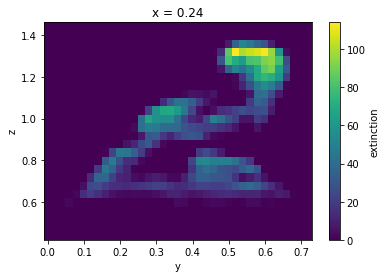

In [43]:
# plot some cross sections
optical_properties[0.86].extinction[12].T.plot()

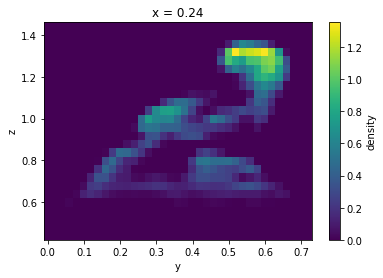

In [44]:
optical_properties[0.86].density[12].T.plot()

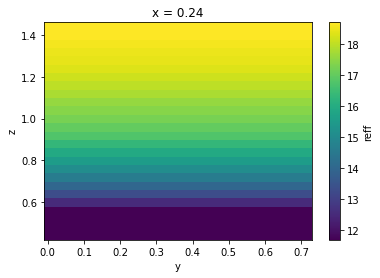

In [45]:
optical_properties[0.86].reff[12].T.plot()